In [1]:
from IPython.display import clear_output

# Install dependencies and 
!pip install albumentations==0.4.6
!pip install pycocotools --quiet
# Clone TorchVision repo and copy helper files
!git clone https://github.com/pytorch/vision.git
%cd vision
!git checkout v0.3.0
%cd ..
!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./

clear_output()

In [2]:
import os
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import torch
from torch import nn
import torchvision
from torchvision import transforms as torchtrans
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import MaskRCNN
from torchvision.models.detection import FasterRCNN

import cv2

from engine import train_one_epoch, evaluate
import utils
import transforms as T

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

# Dataset

In [23]:
dir_train = '/kaggle/input/animals-detection-images-dataset/train'
dir_test = '/kaggle/input/animals-detection-images-dataset/test'


class AnimalImageDataset(torch.utils.data.Dataset):
    def __init__(self, files_dir, width, height, transform=None):
        self.files_dir = files_dir
        self.width = width
        self.height = height
        self.transforms = transform
        
        # Making lists with train imgs and annotations folders 
        self.imgs = sorted(glob.glob(f'{files_dir}/*/*.jpg'))
        self.annot = sorted(glob.glob(f'{files_dir}/*/*/*.txt'))
        
        self.classes = [_] + sorted(os.listdir('/kaggle/input/animals-detection-images-dataset/train')) 
        
    def __getitem__(self, idx):
        img_name = self.imgs[idx]
        image_path = os.path.join(self.files_dir, img_name)
        # reading the images and converting them to correct size and color 
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        # diving by 255
        img_res /= 255.0

        # annotation file
        annot_file_path = self.annot[idx]

        boxes = []
        labels = []

        # cv2 image gives size as height x width
        wt = img.shape[1] / self.width
        ht = img.shape[0] / self.height
        
        with open(annot_file_path) as f:
            for line in f:
                name = ' '.join(i for i in line.split(' ') if i.isalpha())
                parsed = [float(x) for x in line.split(' ')[len(name.split()):]]
                labels.append(self.classes.index(name))
                xmin = int(parsed[0] / wt)
                ymin = int(parsed[1] / ht)
                xmax = int(parsed[2] / wt)
                ymax = int(parsed[3] / ht)
            
        boxes.append([xmin, ymin, xmax, ymax])

        # convert boxes into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        # getting the areas of the boxes
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # suppose all instances are not crowd
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int16)

        labels = torch.as_tensor(labels, dtype=torch.int64)
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        image_id = torch.tensor([idx])
        target["image_id"] = image_id

        if self.transforms:
            sample = self.transforms(image = img_res,
                                    bboxes = target['boxes'],
                                    labels = labels)
            img_res = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
        
        return img_res, target

    def __len__(self):
        return len(self.imgs)


# check dataset
dataset = AnimalImageDataset(dir_train, 224, 224)
print('Length of dataset:', len(dataset), '\n')
classes = dataset.classes
# getting the image and target for a test index.  Feel free to change the index.
img, target = dataset[78]
print('Image shape:', img.shape)
print('Label example:', target)

Length of dataset: 22566 

Image shape: (224, 224, 3)
Label example: {'boxes': tensor([[ 54., 103.,  75., 131.]]), 'labels': tensor([1]), 'area': tensor([588.]), 'iscrowd': tensor([0], dtype=torch.int16), 'image_id': tensor([78])}


# Visualization

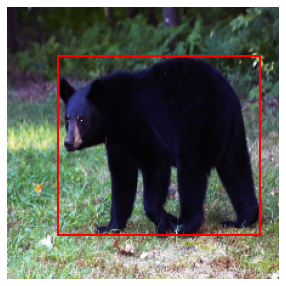

In [4]:
# Function to visualize bounding boxes in the image
def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    for box, text_idx in (target['boxes'].cpu().detach(), target['labels']):
        box = np.array(box, dtype=np.int32)
        x, y, width, height = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle(
          (x, y),
          width, height,
          linewidth = 2,
          edgecolor = 'r',
          facecolor = 'none'
        )
        a[0].text(x, y, classes[text_idx])
        a.add_patch(rect)
        
    plt.axis('off')
    plt.show()
# plotting the image with bboxes. Feel free to change the index
img, target = dataset[55]
plot_img_bbox(img, target)

# Augmentation

In [5]:
# Send train=True for training transforms and False for val/test transforms
def get_transform(train):
    if train:
        return A.Compose(
          [
#             A.HorizontalFlip(0.5),
            # ToTensorV2 converts image to pytorch tensor without div by 255
            ToTensorV2(p=1.0)
          ],
          bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']}
        )
    else:
        return A.Compose(
          [ToTensorV2(p=1.0)],
          bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']}
        )

# Dataloaders

Make a loader for feeding our data into the neural network

In [6]:
dataset = AnimalImageDataset(dir_train, 400, 400, transform=get_transform(train=True))
dataset_test = AnimalImageDataset(dir_test, 400, 400, transform=get_transform(train=False))

indices = torch.randperm(len(dataset)).tolist()

test_split = 0.2
tsize = int(len(dataset) * test_split)

dataset = torch.utils.data.Subset(dataset, indices[:-tsize])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-tsize:])

data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=10,
    shuffle=True,
    num_workers=2,
    collate_fn=utils.collate_fn,
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=10,
    shuffle=False,
    num_workers=2,
    collate_fn=utils.collate_fn
)

# Pre-trained Model

In [7]:
def get_object_detection_model(num_classes):
    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 
    return model

# Filtering the outputs

In [8]:
# the function takes the original prediction and the iou threshold.
def apply_nms(orig_prediction, iou_thresh=0.3):
    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)

    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]

    return final_prediction

# function to convert a torchtensor back to PIL image
def torch_to_pil(img):
    return torchtrans.ToPILImage()(img).convert('RGB')

# Testing pretrained model without train

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

torch.Size([3, 400, 400])


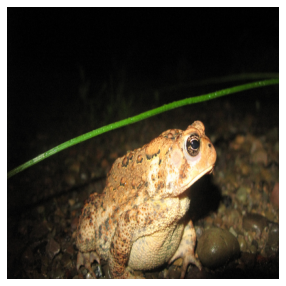

In [9]:
test_model = get_object_detection_model(len(classes))
test_model.eval()
test_model.cuda()
img, target = dataset[1235]
print(img.shape)
with torch.no_grad():
    pred = test_model([img.cuda()])[0]

nms_prediction = apply_nms(pred, iou_thresh=0.01)

plot_img_bbox(torch_to_pil(img), nms_prediction)

# Training

In [10]:
# train on gpu if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = len(classes) # one class (class 0) is dedicated to the "background"

# get the model using our helper function
model = get_object_detection_model(len(classes))

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.05)

# and a learning rate scheduler which decreases the learning rate by
# 10x every epoch
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=2,
    gamma=0.1
)

In [11]:
# training for N epochs
num_epochs = 7

for epoch in range(num_epochs):
    # training for one epoch
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=500)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
#     evaluate(model, data_loader_test, device=device)

Epoch: [0]  [   0/1806]  eta: 1:04:34  lr: 0.000100  loss: 4.6897 (4.6897)  loss_classifier: 4.5002 (4.5002)  loss_box_reg: 0.1823 (0.1823)  loss_objectness: 0.0034 (0.0034)  loss_rpn_box_reg: 0.0037 (0.0037)  time: 2.1453  data: 0.6111  max mem: 7310
Epoch: [0]  [ 500/1806]  eta: 0:23:41  lr: 0.025075  loss: 0.3125 (0.4823)  loss_classifier: 0.1773 (0.3291)  loss_box_reg: 0.1250 (0.1428)  loss_objectness: 0.0045 (0.0062)  loss_rpn_box_reg: 0.0033 (0.0043)  time: 1.0825  data: 0.0384  max mem: 7418
Epoch: [0]  [1000/1806]  eta: 0:14:35  lr: 0.050000  loss: 0.2198 (0.3760)  loss_classifier: 0.1327 (0.2428)  loss_box_reg: 0.0873 (0.1239)  loss_objectness: 0.0016 (0.0052)  loss_rpn_box_reg: 0.0042 (0.0042)  time: 1.0786  data: 0.0393  max mem: 7418
Epoch: [0]  [1500/1806]  eta: 0:05:32  lr: 0.050000  loss: 0.1889 (0.3194)  loss_classifier: 0.1167 (0.2027)  loss_box_reg: 0.0724 (0.1081)  loss_objectness: 0.0015 (0.0046)  loss_rpn_box_reg: 0.0032 (0.0040)  time: 1.0890  data: 0.0411  max me

# Testing our Model

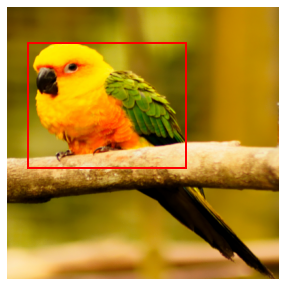

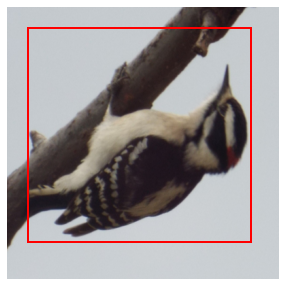

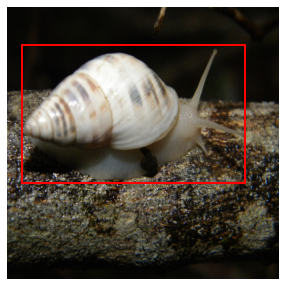

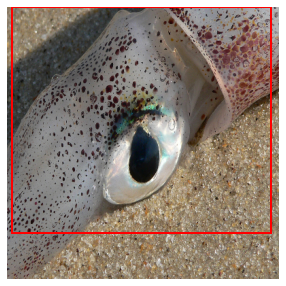

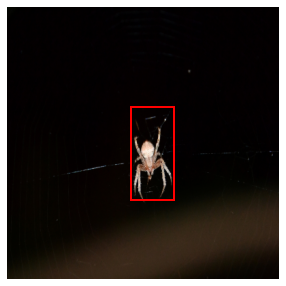

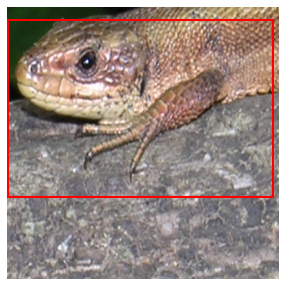

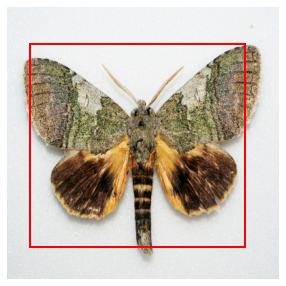

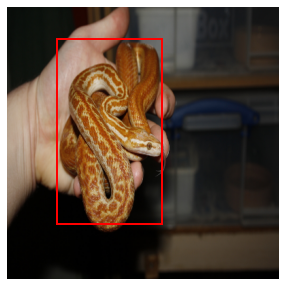

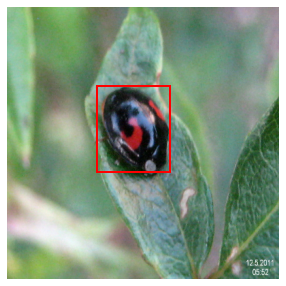

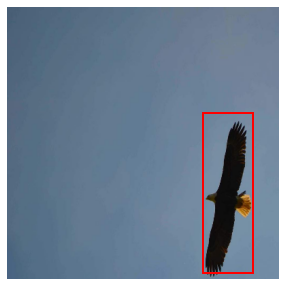

In [24]:
test_dataset = AnimalImageDataset(dir_test, 480, 480, transform=get_transform(train=True))

# pick one image from the test set
img, target = next(iter(data_loader_test))
img = img
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    for i in img:
        prediction = model([i.to(device)])[0]
        nms_prediction = apply_nms(prediction, iou_thresh=0.001)
        plot_img_bbox(torch_to_pil(i), nms_prediction)
